In [1]:
import os                       # for working with files
import numpy as np              # for numerical computationss
import pandas as pd             # for working with dataframes
import torch                    # Pytorch module 
import matplotlib.pyplot as plt # for plotting informations on graph and images using tensors
import torch.nn as nn           # for creating  neural networks
from torch.utils.data import DataLoader, random_split # for dataloaders 
from PIL import Image           # for checking images
import torch.nn.functional as F # for functions for calculating loss
import torchvision.transforms as transforms   # for transforming images into tensors 
from torchvision.utils import make_grid       # for data checking
from torchvision.datasets import ImageFolder  # for working with classes and images
from tqdm import tqdm
import time
from torchvision import models

# For Confusion Matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sn

In [2]:
data_dir = "../input/plantaek6721/PlantaeK"
# data_dir = "/content/drive/MyDrive/COMP6721-Project/PlantVillage-Dataset"

diseases = os.listdir(data_dir)

In [3]:
# printing the disease names
print(diseases)
print("Total disease classes are: {}".format(len(diseases)))

['Apricot___healthy', 'Peach___healthy', 'Pear___healthy', 'Walnut___healthy', 'Peach___diseased', 'Apple___diseased', 'Apricot___diseased', 'Grapes___diseased', 'Walnut___diseased', 'Pear___diseased', 'Cherry___diseased', 'Cranberry___healthy', 'Grapes___healthy', 'Apple___healthy', 'Cherry___healthy', 'Cranberry___diseased']
Total disease classes are: 16


In [4]:
plants = []
NumberOfDiseases = 0
for plant in diseases:
    if plant.split('___')[0] not in plants:
        plants.append(plant.split('___')[0])
    if plant.split('___')[1] != 'healthy':
        NumberOfDiseases += 1

In [5]:
# Unique plants in the dataset
print("Number of plants: {}".format(len(plants)))
print(f"Unique Plants are: ")
for idx, plant in enumerate(plants):
  print(str(idx + 1) + '. ' + plant)


Number of plants: 8
Unique Plants are: 
1. Apricot
2. Peach
3. Pear
4. Walnut
5. Apple
6. Grapes
7. Cherry
8. Cranberry


In [6]:
# Number of images for each disease
disease_class_size = {}
for disease in diseases:
    disease_class_size[disease] = len(os.listdir(data_dir + '/' + disease))
    
# converting the disease_class_size dictionary to pandas dataframe passing index as plant name and number of images as column

img_per_class = pd.DataFrame(disease_class_size.values(), index=disease_class_size.keys(), columns=["no. of images"])
img_per_class

,no. of images
Apricot___healthy,315
Peach___healthy,316
Pear___healthy,314
Walnut___healthy,316
Peach___diseased,314
Apple___diseased,315
Apricot___diseased,315
Grapes___diseased,316
Walnut___diseased,314
Pear___diseased,314


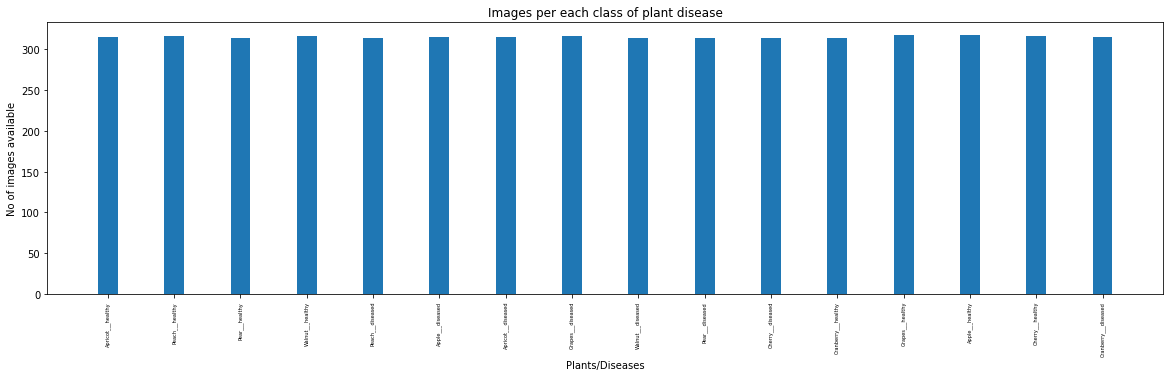

In [7]:
# plotting number of images available for each disease
index = [n for n in range(16)]
plt.figure(figsize=(20, 5))
plt.bar(index, [n for n in disease_class_size.values()], width=0.3)
plt.xlabel('Plants/Diseases', fontsize=10)
plt.ylabel('No of images available', fontsize=10)
plt.xticks(index, diseases, fontsize=5, rotation=90)
plt.title('Images per each class of plant disease')

plt.savefig('/kaggle/working/ClassDistribution_Plantaek_AfterOfflineAugmentation')

In [8]:
## Split Train, Test and Validation ##

def get_files_from_folder(path):
    files = os.listdir(path)
    return np.asarray(files)

get_files_from_folder(data_dir)

def load_data(path, validation_split, test_split, batch_size):
    transform_dict = {
        "src": transforms.Compose([
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.27129, 0.28836, 0.26273], std=[0.09086, 0.12649, 0.08288]),
            transforms.Resize((224, 224))
        ])
    }
    
    dataset = ImageFolder(root=path, transform=transform_dict["src"])
    
    dataset_size = len(dataset)
    validation_size = int(validation_split * dataset_size)
    test_size = int(test_split * dataset_size)
    train_size = dataset_size - (test_size + validation_size)

    # TODO: Split classes into equal sizes?!
    train_dataset, validation_dataset, test_dataset = random_split(dataset, [train_size, validation_size, test_size])
    
    return train_dataset, validation_dataset, test_dataset

In [9]:
train_dataset, validation_dataset, test_dataset = load_data(data_dir, 0.1, 0.2, 200)

In [10]:
img, label = train_dataset[0]
print(img.shape, label)

torch.Size([3, 224, 224]) 15


In [11]:
# for checking some images from training dataset
def show_image(image, label):
    # print("Label :" + train_dataset.classes[label] + "(" + str(label) + ")")
    plt.imshow(image.permute(1, 2, 0))

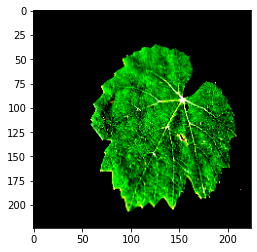

In [12]:
show_image(*train_dataset[21])

In [13]:
# setting the batch size
batch_size = 32

# Load data to DataLoaders for training, validation and test
train_dataloader = DataLoader(train_dataset, batch_size, shuffle=True, num_workers=2, pin_memory=True)
validation_dataloader = DataLoader(validation_dataset, batch_size, num_workers=2, pin_memory=True)
test_dataloader = DataLoader(test_dataset, batch_size, num_workers=2, pin_memory=True)

In [14]:
# helper function to show a batch of training instances
def show_batch(data):
    for images, labels in data:
        fig, ax = plt.subplots(figsize=(30, 30))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=8).permute(1, 2, 0))
        break

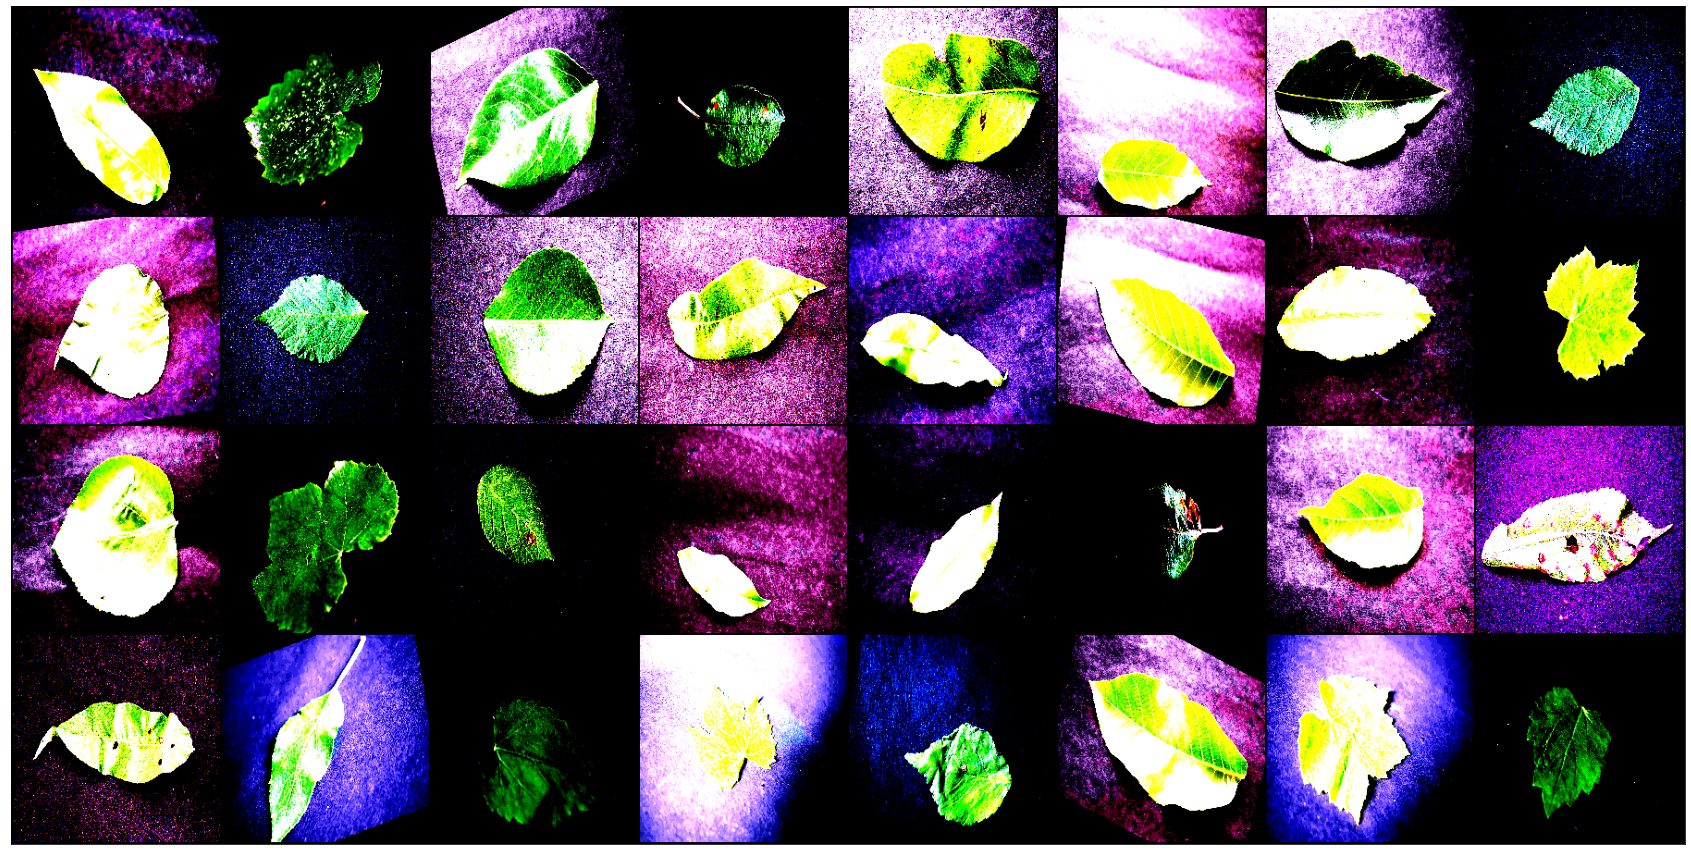

In [15]:
show_batch(train_dataloader)

In [16]:
# for calculating the accuracy
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))


# base class for the model
class ImageClassificationBase(nn.Module):
    
    def training_step(self, batch):
        images, labels = batch
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch
        out = self(images)                   # Generate prediction
        loss = F.cross_entropy(out, labels)  # Calculate loss
        acc = accuracy(out, labels)          # Calculate accuracy
        return {"val_loss": loss.detach(), "val_accuracy": acc}
    
    def validation_epoch_end(self, outputs):
        batch_losses = [x["val_loss"] for x in outputs]
        batch_accuracy = [x["val_accuracy"] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()       # Combine loss  
        epoch_accuracy = torch.stack(batch_accuracy).mean()
        return {"val_loss": epoch_loss, "val_accuracy": epoch_accuracy} # Combine accuracies
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_accuracy']))

In [17]:
# defining the model and moving it to the GPU

model_vgg16 = models.vgg16(pretrained=True)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

In [18]:
for param in model_vgg16.parameters():
    param.requires_grad = False

num_ftrs = model_vgg16.classifier[6].in_features
model_vgg16.classifier[6] = nn.Linear(num_ftrs, out_features=len(train_dataset.dataset.classes))
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device: {}".format(device))
model_vgg16.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_vgg16.classifier[6].parameters(), lr=0.001)

Device: cuda:0


In [19]:
accuracy_validation = []
accuracy_train = []
loss_validation = []
loss_train = []

num_epochs = 40
total_steps = len(train_dataloader)
t1 = time.time()

for epoch in range(num_epochs):
    for i, data in enumerate(train_dataloader):
        images, labels = data[0].to(device), data[1].to(device)
        # Forward pass
        outputs = model_vgg16(images)
        loss = criterion(outputs, labels)
        # Backprop and optimisation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Train accuracy
        total = labels.size(0)
        _,predicted = torch.max(outputs.data, 1)
        correct = (predicted == labels).sum().item()
        if (i + 1) % 10 == 0:
            accuracy = ((correct / total) * 100)
            accuracy_train.append(accuracy)
            loss_train.append(loss.item())
            
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'
                .format(epoch + 1, num_epochs, i + 1, total_steps, loss.item(), accuracy))
            
            model_vgg16.eval()
            with torch.no_grad():
                correct_validation_labels = 0
                total_validation_labels = 0

                for validation_data in validation_dataloader:
                    validation_images, validation_labels = validation_data[0].to(device), validation_data[1].to(device)
                    predicted_outputs = model_vgg16(validation_images)

                    _, validation_prediction = torch.max(predicted_outputs.data, 1)
                    total_validation_labels += validation_labels.size(0)
                    correct_validation_labels += (validation_prediction == validation_labels).sum().item()
                # print("Correct-> ", correct_validation_labels)
                # print("Total-> ", total_validation_labels)
                # print(correct_validation_labels/total_validation_labels)
                val_loss = criterion(predicted_outputs, validation_labels)
                
                val_accuracy = ((correct_validation_labels / total_validation_labels) * 100)
                
                accuracy_validation.append(val_accuracy)
                loss_validation.append(val_loss.item())
            
                print('Epoch [{}/{}], Loss: {:.4f}, Validation Accuracy: {:.2f}%'
                      .format(epoch + 1, num_epochs, val_loss.item(), val_accuracy))
     
print("######## Training Finished in {} seconds ###########".format(time.time()-t1))

Epoch [1/40], Step [10/111], Loss: 2.1722, Accuracy: 21.88%
Epoch [1/40], Loss: 1.9044, Validation Accuracy: 42.26%
Epoch [1/40], Step [20/111], Loss: 1.3566, Accuracy: 65.62%
Epoch [1/40], Loss: 1.5736, Validation Accuracy: 60.71%
Epoch [1/40], Step [30/111], Loss: 1.0700, Accuracy: 62.50%
Epoch [1/40], Loss: 1.2725, Validation Accuracy: 63.29%
Epoch [1/40], Step [40/111], Loss: 0.9909, Accuracy: 68.75%
Epoch [1/40], Loss: 1.0341, Validation Accuracy: 69.25%
Epoch [1/40], Step [50/111], Loss: 0.8447, Accuracy: 75.00%
Epoch [1/40], Loss: 1.0140, Validation Accuracy: 66.87%
Epoch [1/40], Step [60/111], Loss: 0.7066, Accuracy: 81.25%
Epoch [1/40], Loss: 0.8158, Validation Accuracy: 74.60%
Epoch [1/40], Step [70/111], Loss: 0.8239, Accuracy: 59.38%
Epoch [1/40], Loss: 0.8969, Validation Accuracy: 68.06%
Epoch [1/40], Step [80/111], Loss: 0.6973, Accuracy: 81.25%
Epoch [1/40], Loss: 0.8397, Validation Accuracy: 73.61%
Epoch [1/40], Step [90/111], Loss: 0.6444, Accuracy: 84.38%
Epoch [1/40]

In [20]:
torch.save(model_vgg16, '/kaggle/working/Model_Plantaek-Vgg16.pth')

# model = torch.load('model.pth')

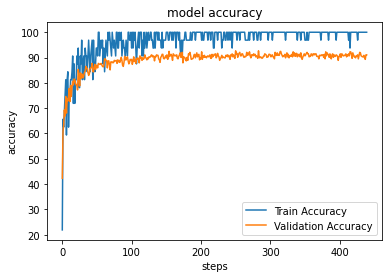

In [21]:
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('steps')
plt.plot(accuracy_train, label="Train Accuracy")
plt.plot(accuracy_validation, label="Validation Accuracy")
plt.legend(loc="lower right")
plt.savefig('/kaggle/working/Accurary_Plot_Plantaek-Vgg16')
plt.show()

In [22]:
str(accuracy_train)

'[21.875, 65.625, 62.5, 68.75, 75.0, 81.25, 59.375, 81.25, 84.375, 62.5, 75.0, 75.0, 81.25, 81.25, 84.375, 90.625, 71.875, 87.5, 71.875, 81.25, 81.25, 90.625, 87.5, 93.75, 78.125, 78.125, 90.625, 87.5, 96.875, 81.25, 87.5, 90.625, 81.25, 93.75, 90.625, 90.625, 84.375, 90.625, 96.875, 90.625, 84.375, 90.625, 93.75, 96.875, 81.25, 96.875, 87.5, 84.375, 87.5, 93.75, 93.75, 90.625, 100.0, 100.0, 90.625, 93.75, 96.875, 93.75, 96.875, 87.5, 93.75, 84.375, 90.625, 96.875, 93.75, 90.625, 100.0, 96.875, 100.0, 96.875, 93.75, 90.625, 100.0, 96.875, 93.75, 96.875, 93.75, 90.625, 100.0, 100.0, 93.75, 93.75, 100.0, 96.875, 96.875, 100.0, 90.625, 93.75, 96.875, 93.75, 93.75, 90.625, 96.875, 93.75, 90.625, 100.0, 100.0, 96.875, 96.875, 100.0, 93.75, 100.0, 93.75, 100.0, 96.875, 100.0, 93.75, 87.5, 93.75, 96.875, 100.0, 93.75, 100.0, 100.0, 100.0, 90.625, 96.875, 90.625, 100.0, 93.75, 96.875, 100.0, 93.75, 96.875, 100.0, 96.875, 96.875, 100.0, 100.0, 96.875, 96.875, 93.75, 93.75, 100.0, 93.75, 100.0, 

In [23]:
str(accuracy_validation)

'[42.26190476190476, 60.71428571428571, 63.29365079365079, 69.24603174603175, 66.86507936507937, 74.60317460317461, 68.05555555555556, 73.61111111111111, 72.81746031746032, 74.8015873015873, 77.77777777777779, 72.61904761904762, 78.96825396825396, 74.60317460317461, 78.37301587301587, 80.55555555555556, 79.16666666666666, 81.54761904761905, 81.34920634920636, 79.96031746031747, 79.16666666666666, 79.16666666666666, 77.18253968253968, 85.31746031746032, 82.93650793650794, 78.76984126984127, 83.92857142857143, 81.74603174603175, 83.53174603174604, 83.13492063492063, 81.94444444444444, 82.73809523809523, 84.12698412698413, 84.52380952380952, 86.5079365079365, 85.9126984126984, 85.71428571428571, 84.12698412698413, 82.93650793650794, 83.53174603174604, 85.51587301587301, 85.9126984126984, 86.11111111111111, 87.6984126984127, 84.52380952380952, 84.32539682539682, 86.30952380952381, 87.3015873015873, 85.31746031746032, 86.90476190476191, 86.90476190476191, 85.9126984126984, 87.6984126984127,

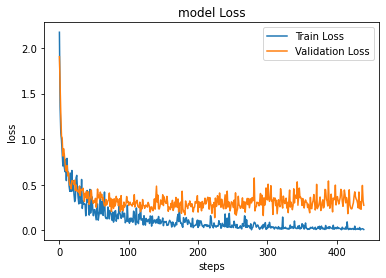

In [24]:
plt.title('model Loss')
plt.ylabel('loss')
plt.xlabel('steps')
plt.plot(loss_train, label="Train Loss")
plt.plot(loss_validation, label="Validation Loss")
plt.legend(loc="upper right")
plt.savefig('/kaggle/working/Loss_Plot_Plantaek-Vgg16')
plt.show()

In [25]:
str(loss_train)

'[2.1722469329833984, 1.3565541505813599, 1.0700335502624512, 0.9908632040023804, 0.8447345495223999, 0.7065824270248413, 0.8238618969917297, 0.6972541213035583, 0.6443734169006348, 0.7795472145080566, 0.5464642643928528, 0.7903504967689514, 0.6055101752281189, 0.6375327110290527, 0.48395562171936035, 0.429484099149704, 0.6284857988357544, 0.4283241629600525, 0.6576159000396729, 0.43383511900901794, 0.5466578006744385, 0.39733466506004333, 0.31624364852905273, 0.34523800015449524, 0.5756493210792542, 0.6042070388793945, 0.45349523425102234, 0.3605338931083679, 0.29076501727104187, 0.48542264103889465, 0.4235983192920685, 0.2985174059867859, 0.5591464638710022, 0.24145537614822388, 0.32536283135414124, 0.29020166397094727, 0.29402610659599304, 0.2887013852596283, 0.16116619110107422, 0.24291181564331055, 0.43845921754837036, 0.3115997612476349, 0.39507874846458435, 0.16856034100055695, 0.4507489502429962, 0.19048583507537842, 0.25762519240379333, 0.36841732263565063, 0.242435023188591, 

In [26]:
str(loss_validation)

'[1.9043526649475098, 1.573631763458252, 1.272515058517456, 1.0340832471847534, 1.013963222503662, 0.8158209323883057, 0.8969466090202332, 0.8396635055541992, 0.7490551471710205, 0.6615707278251648, 0.6517086625099182, 0.7106987833976746, 0.5984235405921936, 0.6360006928443909, 0.5475822687149048, 0.49566563963890076, 0.49285992980003357, 0.4553844630718231, 0.5470717549324036, 0.5446128845214844, 0.5364343523979187, 0.5039913058280945, 0.5511408448219299, 0.439459890127182, 0.49909457564353943, 0.4362855851650238, 0.4269733130931854, 0.44007501006126404, 0.41339871287345886, 0.4835266172885895, 0.3815338611602783, 0.44422993063926697, 0.4510996341705322, 0.4409671127796173, 0.4629127085208893, 0.3991224467754364, 0.3164205849170685, 0.4074644148349762, 0.3633798062801361, 0.4293098449707031, 0.34941697120666504, 0.41852113604545593, 0.4240005910396576, 0.28575006127357483, 0.3488520681858063, 0.3710191249847412, 0.44375061988830566, 0.3458017110824585, 0.3303675353527069, 0.2970358729

In [27]:
model_vgg16.eval()
with torch.no_grad():
    correct_test_labels = 0
    total_test_labels = 0

    for test_data in validation_dataloader:
        test_images, test_labels = test_data[0].to(device), test_data[1].to(device)
        predicted_outputs = model_vgg16(test_images)

        _, test_prediction = torch.max(predicted_outputs.data, 1)
        total_test_labels += test_labels.size(0)
        correct_test_labels += (test_prediction == test_labels).sum().item()

    test_accuracy = ((correct_test_labels / total_test_labels) * 100)
    print("Accuracy on Validation Set: {:.2f}%".format(test_accuracy))

Accuracy on Validation Set: 91.07%


In [28]:
y_pred = []
y_true = []
features_tsne = None

model_vgg16.eval()
with torch.no_grad():
    correct_test_labels = 0
    total_test_labels = 0

    for test_data in test_dataloader:
        test_images, test_labels = test_data[0].to(device), test_data[1].to(device)
        predicted_outputs = model_vgg16(test_images)

        _, test_prediction = torch.max(predicted_outputs.data, 1)
        total_test_labels += test_labels.size(0)
        correct_test_labels += (test_prediction == test_labels).sum().item()
        
        prediction_result = test_prediction.data.cpu().numpy()
        gt_label = test_labels.data.cpu().numpy()
        
        y_pred.extend(prediction_result) # Save Prediction
        y_true.extend(gt_label) # Save Truth
        
        # For t-SNE
        curr_f = predicted_outputs.cpu().numpy()
        if features_tsne is not None:
            features_tsne = np.concatenate((features_tsne, curr_f))
        else:
            features_tsne = curr_f
        
    test_accuracy = ((correct_test_labels / total_test_labels) * 100)
    print("Accuracy on Test Set: {:.2f}%".format(test_accuracy))

Accuracy on Test Set: 91.17%


In [29]:
str(y_pred)

'[7, 8, 1, 14, 9, 13, 6, 8, 13, 10, 7, 11, 8, 10, 13, 8, 14, 7, 5, 12, 4, 14, 13, 14, 5, 4, 4, 15, 7, 12, 11, 11, 0, 13, 12, 0, 3, 14, 9, 10, 14, 9, 15, 13, 12, 10, 3, 13, 12, 5, 4, 11, 3, 7, 1, 8, 13, 6, 4, 11, 0, 5, 15, 7, 12, 12, 4, 3, 12, 0, 13, 0, 4, 14, 9, 3, 10, 14, 9, 15, 10, 14, 5, 13, 9, 1, 11, 13, 14, 6, 0, 11, 0, 1, 6, 3, 5, 2, 9, 4, 4, 6, 3, 11, 11, 9, 15, 11, 6, 4, 1, 8, 10, 2, 12, 0, 2, 9, 7, 2, 10, 2, 13, 11, 14, 6, 12, 10, 15, 12, 2, 9, 10, 7, 14, 12, 0, 8, 7, 13, 1, 8, 6, 7, 8, 10, 4, 0, 9, 11, 14, 7, 0, 2, 7, 0, 9, 10, 5, 5, 3, 7, 10, 1, 6, 1, 0, 11, 13, 11, 5, 11, 0, 5, 11, 5, 8, 0, 11, 11, 11, 11, 11, 13, 3, 7, 3, 2, 5, 14, 1, 2, 8, 14, 11, 14, 8, 8, 5, 9, 9, 10, 10, 15, 4, 9, 5, 4, 1, 1, 8, 1, 6, 7, 12, 15, 9, 11, 5, 13, 4, 1, 12, 1, 14, 15, 13, 10, 8, 4, 12, 1, 9, 4, 12, 3, 15, 1, 5, 11, 14, 10, 0, 10, 13, 8, 14, 2, 5, 2, 2, 0, 4, 4, 14, 2, 10, 2, 12, 5, 9, 12, 3, 1, 14, 8, 8, 0, 12, 9, 6, 1, 12, 2, 8, 14, 9, 8, 0, 15, 2, 11, 13, 8, 5, 7, 12, 5, 13, 6, 12, 9, 2, 

In [30]:
str(y_true)

'[7, 8, 1, 14, 9, 13, 6, 8, 12, 10, 7, 11, 8, 10, 13, 8, 15, 7, 14, 12, 4, 15, 13, 12, 5, 4, 4, 15, 7, 12, 11, 11, 0, 13, 12, 0, 3, 14, 9, 10, 14, 9, 15, 13, 12, 10, 3, 13, 12, 5, 4, 11, 3, 7, 1, 8, 13, 6, 4, 11, 0, 5, 15, 6, 12, 12, 4, 3, 12, 0, 13, 0, 4, 14, 9, 3, 10, 14, 9, 15, 10, 14, 5, 13, 9, 0, 11, 13, 14, 6, 0, 13, 0, 1, 6, 3, 5, 2, 9, 4, 4, 6, 3, 11, 11, 9, 15, 11, 6, 4, 1, 8, 10, 2, 12, 0, 3, 9, 7, 2, 10, 2, 13, 11, 14, 6, 12, 10, 15, 12, 2, 9, 10, 7, 14, 12, 0, 9, 7, 13, 1, 8, 6, 7, 8, 10, 4, 1, 9, 11, 14, 7, 0, 2, 7, 0, 6, 10, 5, 5, 3, 7, 10, 1, 6, 1, 0, 11, 13, 11, 5, 11, 0, 5, 11, 5, 8, 0, 11, 11, 11, 11, 11, 13, 3, 7, 2, 2, 5, 14, 1, 2, 8, 14, 11, 14, 8, 8, 5, 9, 9, 10, 10, 15, 4, 9, 5, 4, 1, 1, 8, 1, 6, 6, 12, 15, 9, 11, 5, 13, 4, 1, 12, 1, 14, 15, 13, 10, 8, 4, 12, 1, 9, 4, 12, 3, 14, 1, 5, 11, 14, 11, 0, 10, 13, 8, 14, 2, 5, 2, 3, 0, 4, 4, 15, 2, 10, 2, 12, 5, 9, 12, 3, 1, 14, 8, 8, 0, 12, 9, 6, 9, 12, 2, 8, 14, 9, 8, 1, 15, 2, 11, 13, 8, 5, 7, 12, 5, 13, 6, 12, 9, 2,

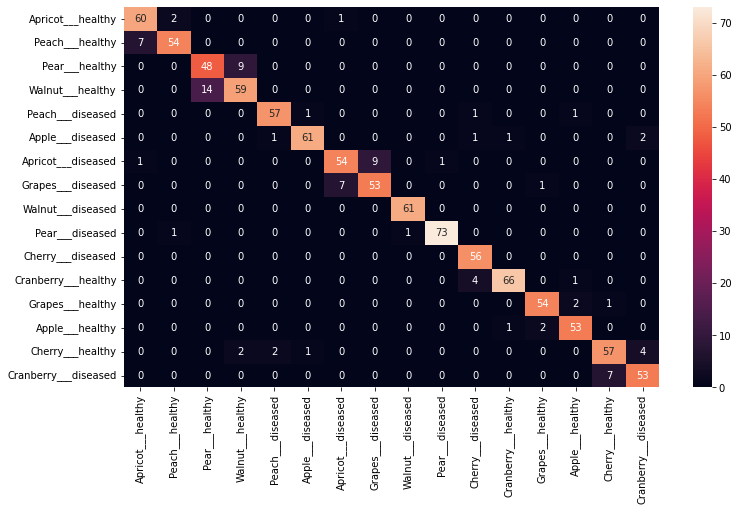

In [31]:
# Create Confusion Matrix
confusion_matrix = confusion_matrix(y_true, y_pred)

df_cm = pd.DataFrame(confusion_matrix,
                     index = [i for i in diseases],
                     columns = [i for i in diseases])
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True)
plt.savefig('/kaggle/working/Confusion_Matrix_Plantaek-Vgg16.png')

In [32]:
# (True Positive + True Negative) / Total Predictions
accuracy = accuracy_score(y_true, y_pred)

# True Positive / (True Positive + False Positive)
precision = precision_score(y_true, y_pred, average='weighted')

# True Positive / (True Positive + False Negative)
sensitivity_recall = recall_score(y_true, y_pred, average='weighted')

# True Negative / (True Negative + False Positive)
specificity = recall_score(y_true, y_pred, average='weighted')

# 2 * ((Precision * Sensitivity) / (Precision + Sensitivity))
f1_score = f1_score(y_true, y_pred, average='weighted')
      
print("Accuracy: {:.2f}%".format(accuracy*100))
print("Precision: {:.2f}%".format(precision*100))
print("Sensitivity_recall: {:.2f}%".format(sensitivity_recall*100))
print("Specificity: {:.2f}%".format(specificity*100))
print("F1 Score: {:.2f}%".format(f1_score*100))

Accuracy: 91.17%
Precision: 91.27%
Sensitivity_recall: 91.17%
Specificity: 91.17%
F1 Score: 91.17%


In [33]:
## TSNE ##

from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, learning_rate= 'auto', init='random').fit_transform(features_tsne)

# scale and move the coordinates so they fit [0; 1] range
def scale_to_01_range(x):
    # compute the distribution range
    value_range = (np.max(x) - np.min(x))

    # move the distribution so that it starts from zero
    # by extracting the minimal value from all its values
    starts_from_zero = x - np.min(x)

    # make the distribution fit [0; 1] by dividing by its range
    return starts_from_zero / value_range


def visualize_both_tsne_points(diseases, tx1, ty1, labels1, tx2, ty2, labels2, title1, title2):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (18, 8))
    
    for disease_index in range(len(diseases)):
        ax1.title.set_text(title1)
        indices = [i for i, l in enumerate(labels1) if l == disease_index]
        current_tx = np.take(tx1, indices)
        current_ty = np.take(ty1, indices)
        ax1.scatter(current_tx, current_ty, label=diseases[disease_index])

    for disease_index in range(len(diseases)):
        ax2.title.set_text(title2)
        indices = [i for i, l in enumerate(labels2) if l == disease_index]
        current_tx = np.take(tx2, indices)
        current_ty = np.take(ty2, indices)
        ax2.scatter(current_tx, current_ty, label=diseases[disease_index])
    
    ax2.legend(bbox_to_anchor=(1, 1.01))
    plt.savefig('/kaggle/working/TNSE_Plot_Plantaek-vgg16.png')
    plt.show()

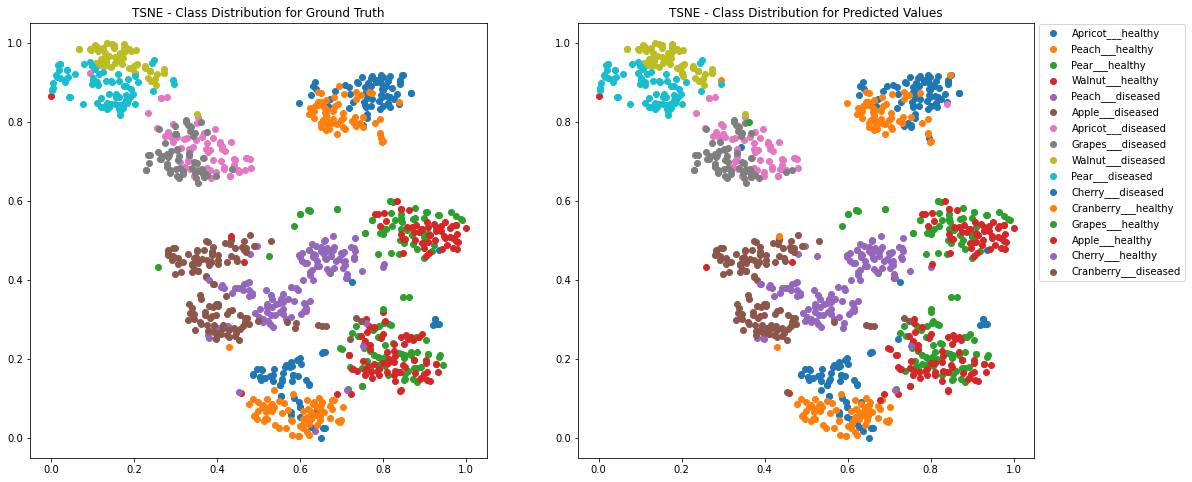

In [34]:
# extract x and y coordinates representing the positions of the images on T-SNE plot
tx_gt = tsne[:, 0]
ty_gt = tsne[:, 1]

# scale and move the coordinates so they fit [0; 1] range
tx_gt = scale_to_01_range(tx_gt)
ty_gt = scale_to_01_range(ty_gt)


# extract x and y coordinates representing the positions of the images on T-SNE plot
tx_pred = tsne[:, 0]
ty_pred = tsne[:, 1]

# scale and move the coordinates so they fit [0; 1] range
tx_pred = scale_to_01_range(tx_pred)
ty_pred = scale_to_01_range(ty_pred)


# visualize the plot
visualize_both_tsne_points(diseases, tx_gt, ty_gt, y_true, tx_pred, ty_pred, y_pred, 'TSNE - Class Distribution for Ground Truth', 'TSNE - Class Distribution for Predicted Values')